# Power simulation for the Supplementary Material of the paper: 'Do adolescents take more risks? Not when facing a novel uncertain situation'

Author: Noémi Éltető
Affiliation: Eötvös Loránd University

Written in Python 2. Numpy is used for stochastic computation, Pandas is used for data frame handling, Matplotlib and Seaborn are used for plotting, and Statmodels is used for regression analysis.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

Based on the regression coefficients reported by Duell et al. (2018), the function below generates the risk-taking scores, given the gender and age of the participant, and an error term. We conduct the power simulation for only the BART, but it can be done for either measures.

In [3]:
def generate_rt_scores(gender,age, error):
    stoplight       = (2.504*gender) + (0.69*age) + ((-0.048)*(age**2)) + error
    bart            = (3.068*gender) + (0.987*age) + ((-0.037)*(age**2)) + error
    health_risk     = (5.996*gender) + (5.009*age) + ((-0.136)*(age**2)) + error
    antisocial_risk = (10.339*gender) + (1.521*age) + ((-0.087)*(age**2)) + error
    return [stoplight, bart, health_risk, antisocial_risk]

We generate 5227 data points to emulate the empirical total sample collected by Duell et al. We sample age uniformly in the range between 0 and 20. This corresponds to the age range between 10 and 30, after centering to 0 (the centering was used in the Duell et al. paper, so we conformed to this in our simulation). The gender term is randomly set to 0 (female) or 1 (male). The error term is set to 9.2, since this ensures that the standard error of the mean of the unstandardized betas approach the standard error values of the parameters as reported by Duell et al. in Table 4.

In [47]:
Duell_simulated_data = pd.DataFrame()
Duell_simulated_data['gender']  = np.random.choice([0,1],5227)
Duell_simulated_data['age']  = np.random.uniform(0,20,5227)
rt_measures = ['stoplight', 'BART', 'health_risk', 'antisocial_risk']
for measure in rt_measures:
    Duell_simulated_data[measure] = np.nan
for i,row in Duell_simulated_data.iterrows():
    Duell_simulated_data.loc[i,rt_measures] = generate_rt_scores(gender = row['gender'],age = row['age'], error=np.random.normal(0,9.25))

The resulting sample of 5227 data points reflects the quadratic pattern that was presented in the paper. The quadratic fit to the simulated data yields similar B and SE(B) values to those reported by Duell et al.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BART   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     145.0
Date:                Tue, 18 Dec 2018   Prob (F-statistic):           2.88e-90
Time:                        14:05:25   Log-Likelihood:                -19070.
No. Observations:                5227   AIC:                         3.815e+04
Df Residuals:                    5223   BIC:                         3.817e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.7555      0.401     -1.883      0.060      -1.542       0.031
gender               3.2514      0.257     12.629      0.000       2.747       3.756
age                  1.1194      0.088     12.731      0.000       0.947       1.292
np.power(age, 2)    -0.0416      0.004     -9.775      0.000      -0.050      -0.033
==============================================================================
Omnibus:                        1.624   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.444   Jarque-Bera (JB):                1.603
Skew:                           0.016   Prob(JB):                        0.449
Kurtosis:                       3.079   Cond. No.                         593.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

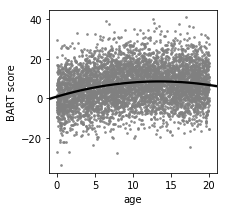

In [48]:
plt.figure(figsize=(3,3))
sns.regplot(x='age',y='BART',order=2,color='grey',scatter_kws={'s':3}, line_kws={'color':'k'}, data=Duell_simulated_data)
plt.xlabel('age')
plt.ylabel('BART score')

model = sm.ols(formula = 'BART ~ gender + age + np.power(age, 2)', data = Duell_simulated_data).fit()
model.summary()

Next, we take n_iterations random subsamples of N=188 from the total sample of 5227, and we test the quadratic fit (F-test) of these random subsamples. We plot the first ten samples and the p-value of the F-test for the quadratic fit. 

In [ ]:
f,ax = plt.subplots(1,10, figsize=(18,1.8), sharex=True,sharey=True)
n_iterations = 10000
r2_values, f_pvalues = [],[]
for i in range(n_iterations):
    subsample = Duell_simulated_data.sample(188)
    model = sm.ols(formula = 'BART ~ gender + age + np.power(age, 2)', data = subsample).fit() # TODO how accounting for gender affects the power?
    r2_values.append(model.rsquared)
    f_pvalues.append(model.f_pvalue)
    if i<10:
        #ax[i].scatter(subsample['age'],subsample['BART'], s=3, alpha=0.7, c='k')
        sns.regplot(x='age',y='BART',order=2,color='grey',scatter_kws={'s':3}, line_kws={'color':'k'}, data=subsample, ax=ax[i])
        pval = np.round(model.f_pvalue,3)
        if pval >= 0.001:
            ax[i].text(0,40,'p = ' +str(pval))
        else:
            ax[i].text(0,40,'p < 0.001')
        ax[i].set_title('Subsample #' + str(i+1))
        ax[i].set_xlabel('age')
        ax[i].set_xlim(-1,21)
        ax[i].set_ylim(-30,50)
        if i==0:
            ax[i].set_ylabel('standardized BART score')
#plt.suptitle('Quadratic fit to 10 examplar random subsamples (N=188) drawn from a simulated population (N=5227) based on reported regression parameters by Duell et al. (2018)')
#plt.tight_layout(rect=[0,0.03,1,0.95])

We compute the statistical power as the proportion of significant F-tests on alpha level of 0.05.

In [46]:
power_p = (len([i for i in range(n_iterations) if (f_pvalues[i]<0.05)])/float(n_iterations))*100
print power_p

80.72


We plot the density histogram and cumulative histogram of the p-values.

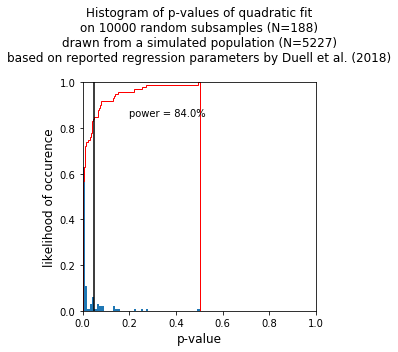

In [44]:
weights = np.ones_like(f_pvalues)/float(len(f_pvalues))
plt.figure(figsize=(5,5))
plt.hist(f_pvalues, weights=weights, bins=50)
plt.hist(f_pvalues,density=True,cumulative=True, bins=100, histtype='step', color='red')
plt.xlim((0,1))
plt.ylim((0,1))
plt.axvline(x=0.05, color='black')
plt.text(0.2,0.85,'power = '+str(power_p)+'%')
plt.xlabel('p-value',fontsize=12)
plt.ylabel('likelihood of occurence',fontsize=12)
plt.title('Histogram of p-values of quadratic fit\non 10000 random subsamples (N=188)\ndrawn from a simulated population (N=5227)\nbased on reported regression parameters by Duell et al. (2018)\n',fontsize=12)
plt.tight_layout()